2.9.2


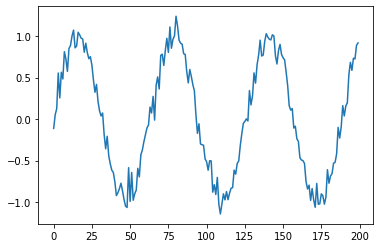

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print(tf.__version__)


# make the original data (synthetic) is a time series
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

# plot it
plt.plot(series)
plt.show()


In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  #print(x)
  X.append(x)
  #Creaiamo blocchi di T = 10 campioni sui quali andrà predetto l'11esimo capione
  #Infatti poi y è l'11esimo campione
  y = series[t+T]
  #print(y)
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i) # 1 output e no activation function (così si fa per le regression)
model = Model(i, x)
model.compile( loss='mse',optimizer=Adam(lr=0.1))

# train the RNN
r = model.fit( X[:-N//2], Y[:-N//2], epochs=80, validation_data=(X[-N//2:], Y[-N//2:]))

#NB I moedelli per il forecasting devono prevedere qualcosa e per allenarli si splitta il dataset a metà,
#prima metà utilizzata per training e seconda metà per testing 

X.shape (190, 10) Y.shape (190,)
Epoch 1/80


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 0s 58ms/step - loss: 0.8540 - val_loss: 0.4035
Epoch 2/80
3/3 [==============================] - 0s 14ms/step - loss: 0.5424 - val_loss: 0.3301
Epoch 3/80
3/3 [==============================] - 0s 13ms/step - loss: 0.1879 - val_loss: 0.1324
Epoch 4/80
3/3 [==============================] - 0s 12ms/step - loss: 0.1903 - val_loss: 0.1518
Epoch 5/80
3/3 [==============================] - 0s 24ms/step - loss: 0.1401 - val_loss: 0.0368
Epoch 6/80
3/3 [==============================] - 0s 22ms/step - loss: 0.0526 - val_loss: 0.0849
Epoch 7/80
3/3 [==============================] - 0s 12ms/step - loss: 0.1016 - val_loss: 0.0461
Epoch 8/80
3/3 [==============================] - 0s 13ms/step - loss: 0.0601 - val_loss: 0.0678
Epoch 9/80
3/3 [==============================] - 0s 14ms/step - loss: 0.0745 - val_loss: 0.0830
Epoch 10/80
3/3 [==============================] - 0s 12ms/step - loss: 0.0625 - val_loss: 0.0344
Epoch 11/80
3/3 [=======================

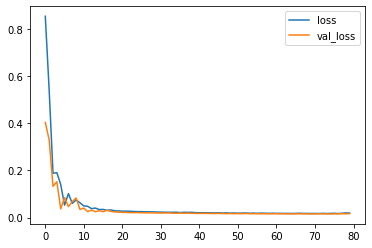

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()


In [ ]:

# "Wrong" forecast using true targets

validation_target = Y[-N//2:] #validazione assegnata come seconda metà di Y
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  #qua si prende un campione di x alla volta perchè ogni x è un vettore di 10 campioni 
  p = model.predict(X[i].reshape(1, -1))[0,0] #returns an 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

1/1 [==============================] - 0s 16ms/step


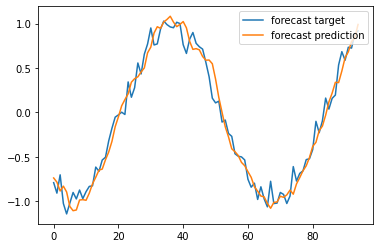

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()


Sembra corretto ma quanto fatto è il modo sbagliato di eseguire il forecasting
Il problema era che utilizzavamo il vettore x per effettuare le previsioni! Ovvero usavamo i veri input per predie il futuro, non va fatto, è un one step prediction.

Invece occorre prendere come primo valore del testing, l'ultimo vero valore noto, campionato, poi si fa tipo FIFO e si appendono come nuovi input le predizioni appena effettuate!

Adesso vediamo come fare correttamente:

1/1 [==============================] - 0s 16ms/step


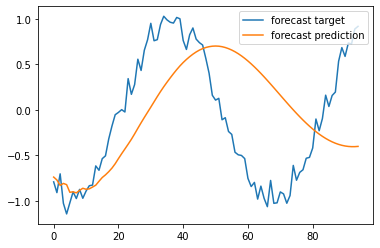

In [ ]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)  #effettua lo shift (tipo buffer circolare però!)
  #roll by -1 means shift everything one spot to the left, the left most value ends up looping back around to the right. 
  #But we replace it anyway with P, l'ultima predizione.
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()



Fin qua tutto ok se il segnale in ingresso non ha rumore!
Con il rumore già cambia ma il risultato è cmq smooth e sembra periodico, good!